# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
% matplotlib inline

import math
import json
import progressbar

### Import Data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1. Access Portfolio Data

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

In [6]:
portfolio.duration.unique()

array([ 7,  5,  4, 10,  3])

In [7]:
portfolio.reward.unique()

array([10,  0,  5,  3,  2])

In [8]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

### Clean Portfolio Data:

- portfolio: rename id col name offer_id.
- portfolio: one-hot encode channels
- portfolio: one-hot encode offer_type column

In [9]:
# portfolio: rename id col name offer_id.
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [10]:
# portfolio: one-hot encode channels

for index, row in portfolio.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in portfolio.loc[index, 'channels']:
            portfolio.loc[index, channel] = 1
        else:
            portfolio.loc[index, channel] = 0
portfolio.drop(columns='channels', inplace=True)

In [11]:
# portfolio: one-hot encode offer_type column

for index, row in portfolio.iterrows():
    for offertype in ['bogo', 'informational', 'discount']:
        if offertype in portfolio.loc[index, 'offer_type']:
            portfolio.loc[index, offertype] = 1
        else:
            portfolio.loc[index, offertype] = 0
portfolio.drop(columns='offer_type', inplace=True)

In [12]:
portfolio.duplicated().sum()

0

### 2. Access Profile Data

In [13]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [15]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

### Clean Profile Data
- profile: rename id col name customer_id.
- profile: change age value 118 to nan.
- profile: create readable date format for became_member_on column.
- profile: drop rows with no gender, income, age data
- profile: add start year column (for analysis)

In [16]:
# access the duplicate values
profile.duplicated().sum()

0

In [17]:
# profile: rename id col name customer_id.
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [18]:
profile.where(profile.age==118).count()

age                 2175
became_member_on    2175
gender                 0
customer_id         2175
income                 0
dtype: int64

In [19]:
# profile: change age value 118 to nan.
profile.age.replace(118, np.nan, inplace=True)

In [20]:
# profile: create readable date format for became_member_on column.
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")

In [21]:
len(profile[profile['gender'].isnull()].index)

2175

In [22]:
# profile: drop rows with no gender, income, age data
profile = profile.drop(profile[profile['gender'].isnull()].index)

In [23]:
# profile: add start_year column
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

In [24]:
profile

,age,became_member_on,gender,customer_id,income,start_year,start_month
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11
13,61.0,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017,9
14,26.0,2014-02-13,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014,2
15,62.0,2016-02-11,F,31dda685af34476cad5bc968bdb01c53,71000.0,2016,2
16,49.0,2014-11-13,M,62cf5e10845442329191fc246e7bcea3,52000.0,2014,11
18,57.0,2017-12-31,M,6445de3b47274c759400cd68131d91b4,42000.0,2017,12


### 3. Access Transcript Data

In [25]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [26]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [27]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### Clean Transcript Data
- transcript: rename person col name to customer_id.
- transcript: create separate columns for amount and offer_id from value col.
- transcript: drop transaction rows whose customer_id is not in profile:customer_id
- transcript: seggregate offer and transaction data 
- transcript: finally drop duplicates if any

In [28]:
# transcript: rename person col name to customer_id.
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [29]:
# transcript: create separate columns for amount and offer_id from value col.

def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]
    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)

# change amount column type to float
transcript.amount.astype('float')

# drop value column
transcript.drop(columns=['value'], inplace=True)

In [30]:
# transcript: drop transaction rows whose customer_id is not in profile:customer_id
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [31]:
# access the duplicate values
transcript.duplicated().sum()

374

In [32]:
# drop the duplicated value, and reset the index
transcript.drop_duplicates(inplace=True)

transcript.reset_index(drop=True, inplace=True)

In [33]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 5 columns):
event          272388 non-null object
customer_id    272388 non-null object
time           272388 non-null int64
offer_id       148431 non-null object
amount         123957 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 10.4+ MB


In [34]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [35]:
# transcript:  seggregate offer and transaction data 

# extract transactions from transcript data
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
11032,54890f68699049c2a04d415abc25e717,0,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
11047,629fc02d56414d91bca360decdfa9288,0,33.90
11051,a97e6f33219c432db82acfa0d19c602d,0,18.59
11055,676506bad68e4161b9bbaffeb039626b,0,18.01
11059,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,19.11
11069,4cbe33c601a5407f8202086565c55111,0,36.19


In [36]:
# transcript:  seggregate offer and transaction data 

# extract offer-related from transcript data
offers_df = transcript[transcript.event!='transaction'].copy()

# one-hot encode offer event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount'], inplace=True)

In [37]:
offers_df

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
5,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
6,4b0da7e80e5945209a1fdddfe813dbe0,0,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
7,c27e0d6ab72c455a8bb66d980963de60,0,3f207df678b143eea3cee63160fa8bed,1,0,0
8,d53717f5400c4e84affdaeda9dd926b3,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
9,f806632c011441378d4646567f357a21,0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0


## Exploratory Data Analysis

### 1. Profile data

In [38]:
profile

,age,became_member_on,gender,customer_id,income,start_year,start_month
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11
13,61.0,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017,9
14,26.0,2014-02-13,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014,2
15,62.0,2016-02-11,F,31dda685af34476cad5bc968bdb01c53,71000.0,2016,2
16,49.0,2014-11-13,M,62cf5e10845442329191fc246e7bcea3,52000.0,2014,11
18,57.0,2017-12-31,M,6445de3b47274c759400cd68131d91b4,42000.0,2017,12


#### Check for any missing values in each column

In [39]:
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
start_year          0
start_month         0
dtype: int64

#### Compute gender distribution in customer's data

In [40]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

#### Stats of customer age and income attributes when income is specified

In [41]:
profile[profile['income'].notnull()].describe()

,age,income,start_year,start_month
count,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,2016.620169,6.695582
std,17.383705,21598.299410,1.198245,3.488853
min,18.000000,30000.000000,2013.000000,1.000000
25%,42.000000,49000.000000,2016.000000,4.000000
50%,55.000000,64000.000000,2017.000000,7.000000
75%,66.000000,80000.000000,2017.000000,10.000000
max,101.000000,120000.000000,2018.000000,12.000000


#### Compute what percent of customers vs which year enrolled as a member

In [42]:
year_count = profile['start_year'].value_counts()

year_count *= 100 / year_count.sum()
year_count

2017    37.767285
2018    24.748735
2016    20.397976
2015    10.772344
2014     4.465430
2013     1.848229
Name: start_year, dtype: float64

#### Compute what percent of customers vs which month enrolled as a member

In [43]:
month_count = profile['became_member_on'].apply(lambda date: date.month).value_counts()

month_count *= 100 / year_count.sum()
month_count.sort_index()

1     1327.0
2     1042.0
3     1145.0
4     1145.0
5     1152.0
6     1105.0
7     1189.0
8     1395.0
9     1299.0
10    1386.0
11    1268.0
12    1372.0
Name: became_member_on, dtype: float64

#### Income distribution as a function a gender

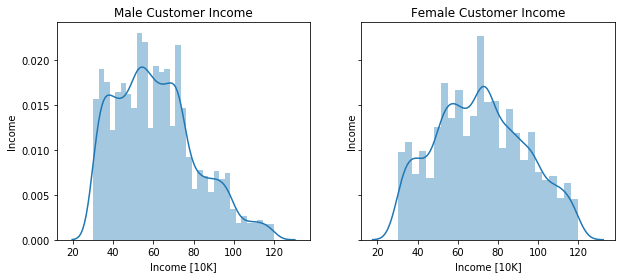

In [44]:
# extract male and female customers
male_customers = profile[profile['gender'] == 'M']
female_customers = profile[profile['gender'] == 'F']

# to be able to draw two subplots in a row
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

# plot a male customers income distribution
plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3)
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Male Customer Income')

# plot a female customers income distribution
plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3)
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Female Customer Income');

- plots conclude that minumum and maximum income for both male and female are approximately same but count of male customers in low income level are slightly higher than that of female customers

#### Age distribution as a function of gender

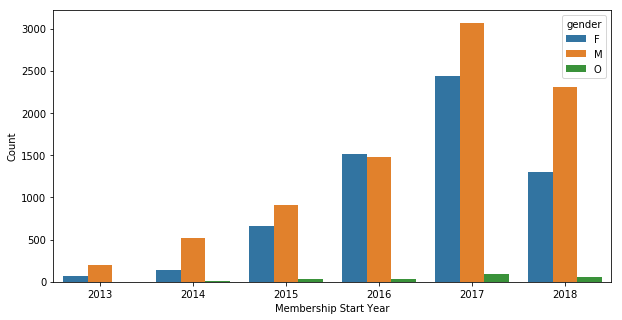

In [45]:
# groupby start_year and gender to plot a graph
membership_date = profile.groupby(['start_year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['start_year', 'gender', 'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='start_year', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

The results suggest that most customers joined the Starbucks rewards program in 2017 followed by 2018. Plots also depict that there are more male customers joining the program every year.

### 2. Transaction data 

#### Compute the event type distribution

In [46]:
event_counts = transcript['event'].value_counts()
event_counts

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [47]:
total_transactions = event_counts.sum()

transactions_perc = 100 * event_counts[0] / total_transactions
offers_perc = 100 * event_counts[1:].sum() / total_transactions

(transactions_perc, offers_perc)

(45.507511344112075, 54.492488655887925)

### Analyse The Number Of Different Transanction Events With Offer

In [187]:
# group a customer and offers by offer event
group_data = data.groupby(["customer_id", "offer_id", "event"]).size().reset_index()
group_data.rename({0:"count"}, axis=1, inplace=True)
group_data.head()

,customer_id,offer_id,event,count
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer_completed,1
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer_received,1
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer_received,1
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer_viewed,1
4,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer_received,1


In [188]:
# use a pivot_table menthod to count the number of events per customer per offer
customer_offers = group_data.pivot_table(index=["customer_id", "offer_id"],  columns=["event"],
                                         values=["count"], aggfunc="count").reset_index()

# set the column names
customer_offers.columns = ["customer_id", "offer_id", "offer_completed", "offer_received", "offer_viewed"]
customer_offers.head()

,customer_id,offer_id,offer_completed,offer_received,offer_viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,1.0,1.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,1.0,1.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0


In [189]:
# fill the missing value with 0
customer_offers.fillna(0, inplace=True)

In [190]:
# merge portfolio data to have complete info about offers
customer_offers_df = customer_offers.merge(portfolio, on='offer_id', how="left")
customer_offers_df

,customer_id,offer_id,offer_completed,offer_received,offer_viewed,difficulty,duration,reward,web,email,social,mobile,bogo,informational,dicsount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,10,7,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0,4,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0,3,0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,5,5,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,10,10,2,1.0,1.0,1.0,1.0,0.0,0.0,0.0
5,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,1.0,20,10,5,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,7,7,3,1.0,1.0,1.0,1.0,0.0,0.0,0.0
7,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0,4,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
8,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0,3,0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
9,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,1.0,5,7,5,1.0,1.0,0.0,1.0,1.0,0.0,0.0


### Analyse The Number Of Different Transanction Events Without Offer

In [191]:
# extract customers data with no offer and groupby customer_id 
no_offer_customer = data.loc[data.offer_id.isnull()].groupby(["customer_id"]).size().reset_index()
no_offer_customer.rename({0:"count"}, axis=1, inplace=True)

In [192]:
no_offer_customer.head()

,customer_id,count
0,0009655768c64bdeb2e877511632db8f,8
1,0011e0d4e6b944f998e987f904e8c1e5,5
2,0020c2b971eb4e9188eac86d93036a77,8
3,0020ccbbb6d84e358d3414a3ff76cffd,12
4,003d66b6608740288d6cc97a6903f4f0,18


### Combine offer, customer and transactions data

In [85]:
# https://progressbar-2.readthedocs.io/en/latest/#introduction

def combine_data(profile, portfolio, offers_df, transaction_df):
    data = []
    customer_ids = offers_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers_df
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        # get customer id from the list
        cust_id = customer_ids[ind]
        
        # extract customer profile from profile data
        customer = profile[profile['customer_id']==cust_id]
        
        # extract offers associated with the customer from offers_df
        cust_offer_data = offers_df[offers_df.customer_id==cust_id]
        
        # extract transactions associated with the customer from transactions_df
        cust_transaction_data = transaction_df[transaction_df.customer_id==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received.iloc[i]['time']
            end_time = start_time + duration_days
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data

In [86]:
data = combine_data(profile, portfolio, offers_df, transaction_df)

 [Elapsed Time: 0:08:28] |##################################| (Time:  0:08:28) 


In [93]:
data

,age,became_member_on,bogo,customer_id,dicsount,difficulty,duration,email,gender,income,...,mobile,offer_id,offer_successful,reward,social,start_month,start_year,time,total_amount,web
0,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,0.0,5,7,1.0,F,100000.0,...,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,0.0,5,2017,408,0.00,1.0
1,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,4,1.0,F,100000.0,...,1.0,3f207df678b143eea3cee63160fa8bed,0,0,0.0,5,2017,504,0.00,1.0
2,68.0,2018-04-26,1.0,e2127556f4f64592b11af22de27a7932,0.0,5,7,1.0,M,70000.0,...,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,0.0,4,2018,408,0.00,1.0
3,68.0,2018-04-26,0.0,e2127556f4f64592b11af22de27a7932,0.0,0,4,1.0,M,70000.0,...,1.0,3f207df678b143eea3cee63160fa8bed,0,0,0.0,4,2018,504,0.00,1.0
4,65.0,2018-02-09,1.0,389bc3fa690240e798340f5a15918d5c,0.0,5,7,1.0,M,53000.0,...,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,0.0,2,2018,408,0.00,1.0
5,65.0,2018-02-09,0.0,389bc3fa690240e798340f5a15918d5c,0.0,0,4,1.0,M,53000.0,...,1.0,3f207df678b143eea3cee63160fa8bed,0,0,0.0,2,2018,504,0.00,1.0
6,58.0,2017-11-11,1.0,2eeac8d8feae4a8cad5a6af0499a211d,0.0,5,7,1.0,M,51000.0,...,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,0.0,11,2017,408,0.00,1.0
7,58.0,2017-11-11,0.0,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,4,1.0,M,51000.0,...,1.0,3f207df678b143eea3cee63160fa8bed,0,0,0.0,11,2017,504,0.00,1.0
8,61.0,2017-09-11,1.0,aa4862eba776480b8bb9c68455b8c2e1,0.0,5,7,1.0,F,57000.0,...,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,0.0,9,2017,408,0.00,1.0
9,61.0,2017-09-11,0.0,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,4,1.0,F,57000.0,...,1.0,3f207df678b143eea3cee63160fa8bed,0,0,0.0,9,2017,504,0.00,1.0


In [95]:
columns_list = ['time', 'offer_id', 'customer_id', 'total_amount', 
                'offer_successful', 'difficulty', 'duration', 
                'reward', 'bogo', 'dicsount', 'informational',
                'email', 'mobile', 'social', 'web', 'became_member_on',
                'gender', 'income', 'age', 'start_year', 'start_month']
data[columns_list]

,time,offer_id,customer_id,total_amount,offer_successful,difficulty,duration,reward,bogo,dicsount,...,email,mobile,social,web,became_member_on,gender,income,age,start_year,start_month
0,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.00,0,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2017-05-09,F,100000.0,75.0,2017,5
1,504,3f207df678b143eea3cee63160fa8bed,78afa995795e4d85b5d9ceeca43f5fef,0.00,0,0,4,0,0.0,0.0,...,1.0,1.0,0.0,1.0,2017-05-09,F,100000.0,75.0,2017,5
2,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,0.00,0,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2018-04-26,M,70000.0,68.0,2018,4
3,504,3f207df678b143eea3cee63160fa8bed,e2127556f4f64592b11af22de27a7932,0.00,0,0,4,0,0.0,0.0,...,1.0,1.0,0.0,1.0,2018-04-26,M,70000.0,68.0,2018,4
4,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,0.00,0,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2018-02-09,M,53000.0,65.0,2018,2
5,504,3f207df678b143eea3cee63160fa8bed,389bc3fa690240e798340f5a15918d5c,0.00,0,0,4,0,0.0,0.0,...,1.0,1.0,0.0,1.0,2018-02-09,M,53000.0,65.0,2018,2
6,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,2eeac8d8feae4a8cad5a6af0499a211d,0.00,0,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2017-11-11,M,51000.0,58.0,2017,11
7,504,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.00,0,0,4,0,0.0,0.0,...,1.0,1.0,0.0,1.0,2017-11-11,M,51000.0,58.0,2017,11
8,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,aa4862eba776480b8bb9c68455b8c2e1,0.00,0,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2017-09-11,F,57000.0,61.0,2017,9
9,504,3f207df678b143eea3cee63160fa8bed,aa4862eba776480b8bb9c68455b8c2e1,0.00,0,0,4,0,0.0,0.0,...,1.0,1.0,0.0,1.0,2017-09-11,F,57000.0,61.0,2017,9


In [96]:
data.to_csv('master_offer_analysis.csv', index=False)

In [97]:
df = pd.read_csv('master_offer_analysis.csv')